# Data and Image Compression with the SVD


All images are effictively matrices. Each value of the matrix corresponds to a pixel in the image.
In the case of a black and white image (grayscale) the value associated with a pixel represents how light or dark the pixel is supposed to be. 

An example of this can be seen in the following $512 \times 512$ image of a boat from *The USC-SIPI Image Database*. The following code reads in the boat image and feeds the data of the image into a numpy array.

TIFF (512, 512) L
[[127 123 125 ... 165 169 166]
 [128 126 128 ... 169 163 167]
 [128 124 128 ... 178 160 175]
 ...
 [112 112 115 ... 101  97 104]
 [110 112 117 ... 104  93 105]
 [113 115 121 ... 102  95  97]]


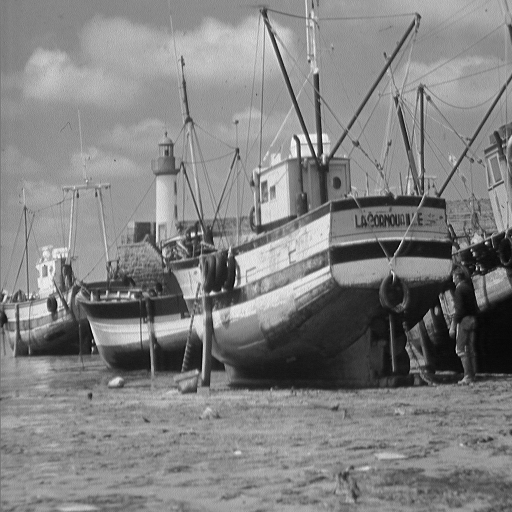

In [1]:
from PIL import Image
import numpy as np

# Read in image
boat = Image.open("boat512.tiff")
print(boat.format, boat.size, boat.mode)
# convert image to a numpy array
boat_matrix = np.asarray(boat)
print(boat_matrix)
display(boat)

With images being matrices, we can do matrix operations on them such as transformations and decompositions.
The following shows the transpose of the boat image.

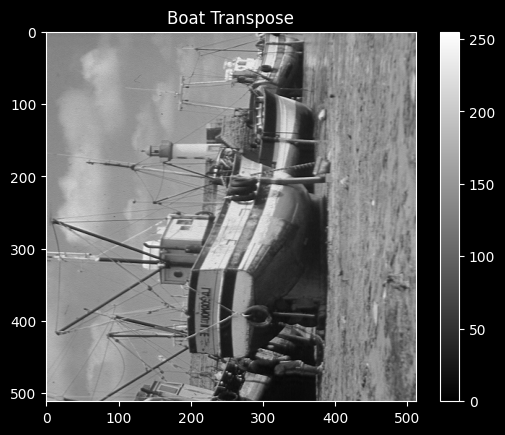

In [8]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")
fig, a = plt.subplots()
a.set_title("Boat Transpose")
plt.imshow(boat_matrix.T, cmap='gray')
plt.colorbar()
plt.show()

Obviously with the title of this being *Data and Image Compression with the SVD*, we'll perform a SVD on the boat image.
If you need a refresher on the SVD, check out the notebook here: https://github.com/nkphysics/Computational-Linear-Algebra-/blob/master/Unit3/SVD/svd.ipynb

The following is a visualization of the $U, \Sigma,$ and $V^T$ matrices from the SVD.

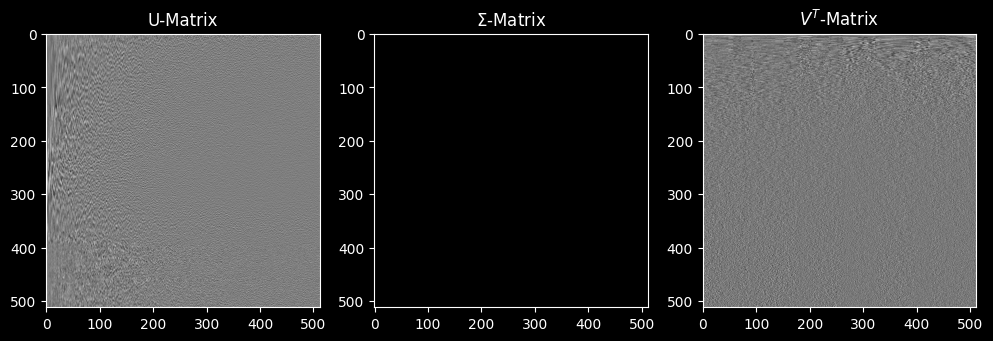

In [3]:
u, sig, vt = np.linalg.svd(boat_matrix)

fig, (aa, ab, ac) = plt.subplots(1, 3, figsize=(12,4))
aa.imshow(u, cmap='grey')
aa.set_title("U-Matrix")
ab.imshow(sig * np.diag(sig), cmap='grey')
ab.set_title(r"$\Sigma$-Matrix")
ac.imshow(vt, cmap='grey')
ac.set_title(r"$V^T$-Matrix")
plt.show()

As we can see in the above visualiztions of the three matrices, the $U$ and $V^T$ matrics just look like a blurry mess and look nothing like the boat from the full image displayed before. Recall, that these matrices contain the right and left singular vectors respectively.
Also notice that with these matrices, the most volitility or magnitude of blurryness comes from the first $~150$ columns of $U$ and first $~150$ rows of $V^T$. Keeping note of this will be important for later on.

The $\Sigma$ matrix looks empty though. The following code produces a zoomed in visualization of the first $10 \times 10$ dimensions of $\Sigma$ on a log scale for a better view of the $\Sigma$ matrix:

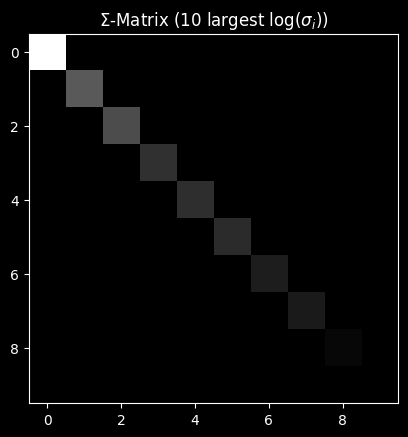

In [4]:
import warnings

fig, ab = plt.subplots()
sig_matrix = np.diag(sig)
# Divide by zero warning suppressed since we expect this from the diagonals
warnings.filterwarnings('ignore')
ab.imshow(np.log(sig_matrix[:10, :10]), cmap='grey')
ab.set_title(r"$\Sigma$-Matrix (10 largest $\log(\sigma_i)$)")
plt.show()

From the above image, it is clear that $\Sigma$ is diagonal. The reason that this is not visible with the full matrix due to the dimensions being $512 \times 512$, and also because there are 512 total $\sigma_i$. Recall that the $\sigma_i$ are strictly positive and ordered from greatest to least running down the diagonal of $\Sigma$. The first few $\sigma_i$ are so great in magnitude that, as seen in the above image, by the $\sigma_9$ it is hard to see visualize the greyscale shade of the pixel even on a logarithmic scale.

So how does any of this help with, or factor into image compression?

Recall the dimensions of the matrices involved with the SVD:

$\mathbf{A}_{m \times n} = \mathbf{U} \Sigma \mathbf{V}^T$

where:

* $\mathbf{U}$ is an $m \times r$ orthonormal matrix, where $r$ is the rank of $\mathbf{A}$.
* $\Sigma$ is an $r \times r$ diagonal matrix containing the singular values of $\mathbf{A}$.
* $\mathbf{V}$ is an $n \times r$ orthonormal matrix.

The point to focus on is the $r$ dimension being the rank of the original $A$ matrix. **This is because all matrices can be reconstructed as combinations of rank 1 matrices.** Rather conveniently, a singular trio of a left singuler vector, singular value, and right singular vector, multiplied in the following manner, will result in a rank 1 matrix of the same dimensions as the orignal $A$ matrix. 

$\sigma_i \begin{bmatrix}\vdots \\ \vec{u_i} \\ \vdots \end{bmatrix}_{m \times 1} \begin{bmatrix}\cdots & \vec{v_i}^T & \cdots \end{bmatrix}_{1 \times n}$

Where $i$ is the index of the singular trio where $\vec{u_i}$ is the $i$th column of $U$, $\vec{v_i}^T$ is the $i$th row of $V^T$, and $\sigma_i$ is the $i$th singular value.

Each singular trio will compute a rank one matrix that is used in the reconstruction of the original matrix.

In the case of the boat image, it has dimensions of $512 \times 512$ so it can be broken into the sum of 512 different rank 1 matrices. What the SVD does for us is it gives us all singular trios of right and left singular vectors and singular values to produce and sum all rank 1 matrices for the $A$ matrix. 

However, we do not need to sum all rank 1 matrices to get a good approximation of $A$ when reconstructing it. From the above column and row vector multiplication, we can see that $\sigma_i$ is just a scalar for the rank 1 matrix produced with the singular trio. Since singular values are sorted from greatest to least down the diagonal in $\Sigma$, its reasonable to understand that rank 1 matrices constructed from smaller indices of singular trios will have a greater magnitude or impact on the reconstruction of the original matrix. Therefore, there will be a point where a computed rank 1 matrix will have a negligable impact on the reconstruction of our matrix $A$. By pruning the SVD of all singular trios after this index, we can retain a surprisingly accurate representation of the original matrix/image while significantly reducing the amount of data required to produce it.

To better visualize this process, the following animation shows what happens to the boat image as we introduce rank 1 matrices from each $\sigma_i$ to resonstruct the original boat image.

In [5]:
import matplotlib.animation as animation
from IPython.display import HTML

compressed = np.matrix(u[:, :1]) * np.diag(sig[:1]) * np.matrix(vt[:1, :])

fig, (cimage, sigs) = plt.subplots(1, 2, figsize=(10, 4))
im = cimage.imshow(compressed, cmap='gray')
cimage.set_title("Compressed Image Using 1 $\sigma_i$")
sigs.set_title("Singular Values")
sigs.set_xlabel("Singular Value Index (i)")
sigs.set_yscale("log")
sigs.set_ylabel("$\sigma_i$ (log)")
sig_plot = sigs.plot(np.arange(1, len(sig) + 1),
                     sig,
                     label="$\sigma_i$")
sig_scat = sigs.scatter(np.arange(1, 2),
                        sig[0:1],
                        color="red",
                        s=10,
                        label="$\sigma_i$ used in image")
sigs.legend()


def update(sigmas: int):
    cimage.set_title(f"Compressed Image Using {sigmas} $\sigma_i$")
    compressed = np.matrix(u[:, :sigmas]) * np.diag(sig[:sigmas]) * np.matrix(vt[:sigmas, :])
    im.set_data(compressed)
    data = np.stack([np.arange(1, sigmas + 1), sig[0:sigmas]]).T
    sig_scat.set_offsets(data)
    return (cimage, sigs)

plt.close()
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(sig), interval=100)
HTML(ani.to_html5_video())

From the above animation it can be seen that the majority of the detail of the boat image is available to us after using the first 100 $\sigma_i$. From the plot on the right we can also see that the first 100 $\sigma_i$ are $>= 200$ in value. So the earlier indexed and greater in magnitude $\sigma_i$ contribute much more to the overall construction of the image. If we decided that after 100 $\sigma_i$ the image will have negligable improvment, we can throw away the remaining 312 $\sigma_i$ and their corresponding right and left singular vectors from $U$ and $V^T$. Thus, the following matrix multiplication is performed in creating an approximation of the original matrix.

$A \approx U_{m \times q} \Sigma_{q \times q} V^T_{q \times n}$

Where $q$ is the cutoff point as described previously.

From the computation of an approximate $A$ matrix, we can see that the approximate matrix will have the same $m \times n$ dimensions of the full $A$ matrix. So where does the data compression come in? After all, the original boat image required $512 \times 512 = 262,144$ values to construct. Since the approximate image will have the same dimensions, it will take the same amount of data, but will just be missing some of the smaller details.

The data compression comes in if we leave our approximted matrix in the form of the 3 shortened $U \Sigma V^T$. In the case of the boat image, if we were to cutoff everything after the first 100 $\sigma_i$ the the shortened matrices would have the following dimensions.

$A \approx U_{512 \times 100} \Sigma_{100 \times 100} V^T_{100 \times 512}$

The shortened $U$ and $V^T$ will then contain 51,200 values each. $\Sigma$ will contain 10,000. Meaning in total we would be storing 112,400 instead of 262,144 if we stored the original full boat image or matrix. That mean the compressed form of the image in the shortened matrices from the SVD is $~42%$ of the original. Or course it we would still take up the full 262,144 values after we perform the matrix multiplication to reform the image/matrix.

The benefit of using the animation previously created, and working with images means that we can visibly see the $\sigma_i$ we would want to stop at. If we were to do this with a matrix of non-visual data, or did not have the animation to work with, there would have to be another way (and there is) of determing the best stopping point.

## Color Images

Before concluding, if we consider the case of color images, they just a combination of 3 matrices for red, green, and blue components of the image. So for compressing the data of color images, all of the total values discussed previouly would scale by a factor of 3 for the red, green, and blue components of the image, if we choose the same stopping point for each color component (which in certain cercumstances is not the case).

The following code demonstrates what we did before for the greyscale boat image, but on the very popular image of the Crab Nebula created by *NASA, ESA and Allison Loll/Jeff Hester (Arizona State University)*. I research pulsars and super nova remnants, so you must understand that whenever I can include pulsars or super novae into something, I absolutely will.

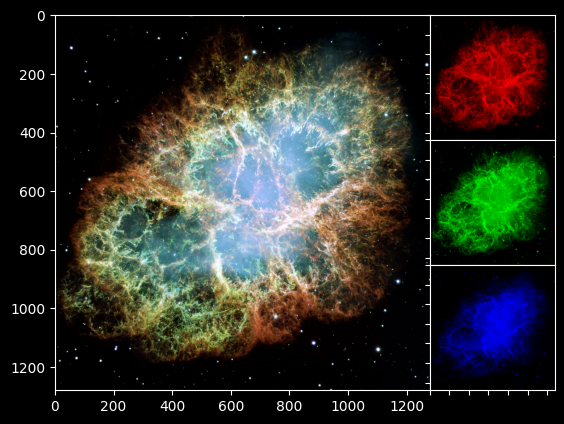

In [17]:
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes

# Read in image
crab = Image.open("heic0515a-small.jpg")
# split crab image into it's components
crab = crab.convert("RGB").split()
rcrab = np.asarray(crab[0])
gcrab = np.asarray(crab[1])
bcrab = np.asarray(crab[2])
# Plotting
fig = plt.figure(figsize=(5, 5))
ax = RGBAxes(fig, [0.2, 0.2, 1.0, 1.0], pad=0.0)
ax.imshow_rgb(rcrab, gcrab, bcrab)
# The following 2 lines are to add in an image credit to the image.
# Uncomment if you plan on saving/sharing the following image and rerun cell to add credit info to image
# imcredit = ("Image Credit for original image: \n"
#             "    NASA, ESA and Allison Loll/Jeff Hester (Arizona State University). \n"
#             "    Acknowledgement: Davide De Martin (ESA/Hubble)")
# plt.text(-4000, 2000, imcredit, fontsize=10)
plt.show()

Image Credit: 

NASA, ESA and Allison Loll/Jeff Hester (Arizona State University). Acknowledgement: Davide De Martin (ESA/Hubble)

[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)

In [18]:
from mpl_toolkits.axes_grid1.axes_rgb import make_rgb_axes


def make_color_image(r, g, b):
    x, y = r.shape
    R = np.zeros((x, y, 3))
    r = r / np.max(r)
    R[:, :, 0] = np.clip(r, 0, 1)
    G = np.zeros_like(R)
    g = g / np.max(g)
    G[:, :, 1] = np.clip(g, 0, 1)
    B = np.zeros_like(R)
    b = b / np.max(b)
    B[:, :, 2] = np.clip(b, 0, 1)
    RGB = R + G + B
    RGB = RGB / np.max(RGB)

    return R, G, B, RGB

r_u, r_sig, r_vt = np.linalg.svd(rcrab)
g_u, g_sig, g_vt = np.linalg.svd(gcrab)
b_u, b_sig, b_vt = np.linalg.svd(bcrab)


cr = np.matrix(r_u[:, :1]) * np.diag(r_sig[:1]) * np.matrix(r_vt[:1, :])
cg = np.matrix(g_u[:, :1]) * np.diag(g_sig[:1]) * np.matrix(g_vt[:1, :])
cb = np.matrix(b_u[:, :1]) * np.diag(b_sig[:1]) * np.matrix(b_vt[:1, :])

fig, ax = plt.subplots()
ax_r, ax_g, ax_b = make_rgb_axes(ax)
# cimage.set_title("Compressed Image Using 1 $\sigma_i$")


def update(sigmas: int):
    # cimage.set_title(f"Compressed Image Using {sigmas} $\sigma_i$")
    sigmas = sigmas * 5
    ax.set_title(f"Compressed Image Using {sigmas} $\sigma_i$")
    cr = np.matrix(r_u[:, :sigmas]) * np.diag(r_sig[:sigmas]) * np.matrix(r_vt[:sigmas, :])
    cg = np.matrix(g_u[:, :sigmas]) * np.diag(g_sig[:sigmas]) * np.matrix(g_vt[:sigmas, :])
    cb = np.matrix(b_u[:, :sigmas]) * np.diag(b_sig[:sigmas]) * np.matrix(b_vt[:sigmas, :])
    
    im_r, im_g, im_b, im_rgb = make_color_image(cr, cg, cb)
    ax.imshow(im_rgb)
    ax_r.imshow(im_r)
    ax_g.imshow(im_g)
    ax_b.imshow(im_b)
    return ax

plt.close()
ani = animation.FuncAnimation(fig=fig, func=update, frames=(len(sig) // 5), interval=250)
HTML(ani.to_html5_video())

## Reference Links

https://sipi.usc.edu/database/database.php

https://www.youtube.com/watch?v=UyAfmAZU_WI&t=345s

https://esahubble.org/images/heic0515a/

### CC License Link for Crab Image

https://creativecommons.org/licenses/by/4.0/